In [7]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class BurgersDataset(Dataset):
    def __init__(self, data_dir, future_steps=1, min_max_path=None):
        """
        Args:
            data_dir (str): Path to the directory with the preprocessed `.npy` files.
            future_steps (int): Number of timesteps in the future the model will predict.
            min_max_path (str): Path to the JSON file containing min and max values for each channel.
        """
        self.data_dir = data_dir
        self.files = sorted([
            os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npy')
        ])
        self.future_steps = future_steps

        if not self.files:
            raise ValueError(f"No .npy files found in the specified directory: {data_dir}")

        # Load min and max values
        if min_max_path is None:
            min_max_path = os.path.join(data_dir, 'min_max.json')
        if not os.path.exists(min_max_path):
            raise FileNotFoundError(
                f"Min and max values file not found at '{min_max_path}'. "
                "Please ensure the file exists."
            )

        with open(min_max_path, 'r') as f:
            min_max = json.load(f)
        self.channel_min = min_max['channel_min']
        self.channel_max = min_max['channel_max']

        # Validate the min and max lists
        if not (len(self.channel_min) == len(self.channel_max)):
            raise ValueError("channel_min and channel_max must have the same length.")
        self.num_channels = len(self.channel_min)

        # Precompute the number of samples per file without loading data
        self.samples = []
        print("Preparing dataset samples...")
        for file_idx, file in enumerate(self.files):
            # Use memory mapping to access the shape without loading data
            try:
                data_memmap = np.load(file, mmap_mode='r')
                timesteps = data_memmap.shape[0]  # Assuming shape: (timesteps, channels=3, height, width)
                del data_memmap  # Close the memmap
            except Exception as e:
                raise ValueError(f"Error loading file '{file}': {e}")

            # Determine the number of valid samples in this file
            max_start_t = timesteps - self.future_steps - 1  # -1 because t starts at 0
            if max_start_t < 0:
                print(f"File '{file}' has insufficient timesteps ({timesteps}) for future_steps={self.future_steps}. Skipping.")
                continue  # Skip files that don't have enough timesteps

            for start_t in range(0, max_start_t + 1):
                self.samples.append((file_idx, start_t))

        print(f"Total samples in dataset: {len(self.samples)}")

        # Precompute t1 assuming all files have the same number of timesteps
        if len(self.files) > 0:
            try:
                sample_memmap = np.load(self.files[0], mmap_mode='r')
                timesteps = sample_memmap.shape[0]  # Assuming shape: (timesteps, channels=3, height, width)
                del sample_memmap
                whole_t = timesteps + 1  # As per original code
                self.t1 = torch.tensor(
                    [(i + 1) / whole_t for i in range(self.future_steps)],
                    dtype=torch.float32
                )  # Shape: (future_steps,)
                self.t0 = torch.tensor(0.0, dtype=torch.float32)  # Scalar
            except Exception as e:
                raise ValueError(f"Error accessing timesteps from the first file: {e}")
        else:
            raise ValueError("No valid .npy files found in the specified directory.")

        # Initialize a cache for memory-mapped files to improve performance
        self._memmap_cache = {}

    def __len__(self):
        return len(self.samples)

    def normalize_channel(self, tensor, channel_idx):
        """
        Normalizes a specific channel of the tensor between 0 and 1.

        Args:
            tensor (torch.Tensor): The tensor to normalize.
            channel_idx (int): The index of the channel to normalize.

        Returns:
            torch.Tensor: The normalized tensor.
        """
        min_val = self.channel_min[channel_idx]
        max_val = self.channel_max[channel_idx]
        if max_val - min_val == 0:
            raise ValueError(
                f"Max and min values for channel {channel_idx} are the same. Cannot normalize."
            )
        tensor[:, channel_idx, :, :] = (tensor[:, channel_idx, :, :] - min_val) / (max_val - min_val)
        return tensor

    def __getitem__(self, idx):
        # Retrieve the (file_idx, start_t) tuple for this sample
        file_idx, start_t = self.samples[idx]
        file = self.files[file_idx]

        # Check if the memmap for this file is already cached
        if file not in self._memmap_cache:
            try:
                # Memory-map the file and store in cache
                data_memmap = np.load(file, mmap_mode='r')
                self._memmap_cache[file] = data_memmap
            except Exception as e:
                raise ValueError(f"Error loading file '{file}': {e}")

        data_memmap = self._memmap_cache[file]

        # Convert to PyTorch tensor
        try:
            # Access the required timesteps: start_t to start_t + 1 + future_steps
            required_timesteps = slice(start_t, start_t + 1 + self.future_steps)
            data = data_memmap[required_timesteps, :, :, :]  # Shape: (future_steps +1, 3, height, width)
        except Exception as e:
            raise ValueError(f"Error accessing timesteps {start_t} to {start_t + self.future_steps +1} in file '{file}': {e}")

        # **Make a writable copy of the data**
        data_copy = data.copy()

        # Convert to PyTorch tensor
        data_tensor = torch.from_numpy(data_copy).float()  # Shape: (future_steps +1, 3, height, width)

        # Normalize each channel between 0 and 1 using precomputed min and max
        for channel_idx in range(self.num_channels):
            data_tensor = self.normalize_channel(data_tensor, channel_idx)

        # Extract input timestep
        ic = data_tensor[0]  # Shape: (3, height, width)

        # Prepare the target sequence (ground truth)
        target = data_tensor[1:]  # Shape: (future_steps, 3, height, width)

        return ic, self.t0, self.t1, target

    def __del__(self):
        # Close all memmap files when the dataset is deleted
        for memmap in self._memmap_cache.values():
            del memmap
        self._memmap_cache.clear()

def custom_collate_fn(batch):
    """
    Custom collate function to rearrange the target tensor.

    Args:
        batch: A list of tuples (ic, t0, t1, target)

    Returns:
        Batched tensors and fixed time indicators:
            - ic: (batch_size, 3, height, width)
            - t0: 0.0 (scalar tensor)
            - t1: (future_steps,) tensor
            - target: (future_steps, batch_size, 3, height, width)
    """
    ic, t0, t1, target = zip(*batch)
    
    # Stack the initial conditions into a tensor
    ic = torch.stack(ic, dim=0)           # (batch_size, 3, height, width)
    
    # Since t0 is always 0.0, return a single scalar tensor
    t0 = torch.tensor(0.0, dtype=torch.float32)  # Scalar tensor
    
    # Since t1 is consistent across all samples, take the first one
    t1 = t1[0]                             # (future_steps,)
    
    # Stack targets into a tensor and permute to match desired shape
    target = torch.stack(target, dim=0).permute(1, 0, 2, 3, 4)  # (future_steps, batch_size, 3, height, width)
    
    return ic, t0, t1, target

# Example usage:
if __name__ == "__main__":
    # Paths to your new train and test directories
    data_dir_train = '/project/vil_baek/data/physics/PARCTorch/Burgers/train'  # Replace with your actual train directory path
    data_dir_test = '/project/vil_baek/data/physics/PARCTorch/Burgers/test'    # Replace with your actual test directory path

    # Define the number of future steps you want
    future_steps = 25  
    
    # Path to the min_max.json file
    # Ensure that 'min_max.json' exists in the data directories
    min_max_path = os.path.join('..', 'Data', 'burgers_min_max.json')

    # Initialize the datasets with the path to min_max.json
    burgers_train_dataset = BurgersDataset(data_dir_train, future_steps=future_steps, min_max_path=min_max_path)
    burgers_test_dataset = BurgersDataset(data_dir_test, future_steps=future_steps, min_max_path=min_max_path)

    # Create DataLoaders for batching with the custom collate function
    batch_size = 4  # Specify your desired batch size

    # **Set num_workers to 1 to comply with system recommendations**
    data_loader_train = DataLoader(
        burgers_train_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,                # Changed from 4 to 1
        pin_memory=True,              # If using a GPU, else set to False
        collate_fn=custom_collate_fn  # Use the custom collate function
    )

    data_loader_test = DataLoader(
        burgers_test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,                # Changed from 4 to 1
        pin_memory=True,              # If using a GPU, else set to False
        collate_fn=custom_collate_fn  # Use the custom collate function
    )
    
    # Example to inspect a batch from the training DataLoader
    for batch in data_loader_train:
        ic, t0, t1, target = batch
        print("Train - ic shape:", ic.shape)          # (batch_size, 3, height, width)
        print("Train - t0:", t0)                      # 0.0
        print("Train - t1:", t1)                      # (future_steps,)
        print("Train - target shape:", target.shape)  # (future_steps, batch_size, 3, height, width)
        break  # Remove this to iterate through the entire dataset

    # Example to inspect a batch from the testing DataLoader
    for batch in data_loader_test:
        ic, t0, t1, target = batch
        print("Test - ic shape:", ic.shape)          # (batch_size, 3, height, width)
        print("Test - t0:", t0)                      # 0.0
        print("Test - t1:", t1)                      # (future_steps,)
        print("Test - target shape:", target.shape)  # (future_steps, batch_size, 3, height, width)
        break  # Remove this to iterate through the entire dataset


Preparing dataset samples...
Total samples in dataset: 7600
Preparing dataset samples...
Total samples in dataset: 28728
Train - ic shape: torch.Size([4, 3, 64, 64])
Train - t0: tensor(0.)
Train - t1: tensor([0.0098, 0.0196, 0.0294, 0.0392, 0.0490, 0.0588, 0.0686, 0.0784, 0.0882,
        0.0980, 0.1078, 0.1176, 0.1275, 0.1373, 0.1471, 0.1569, 0.1667, 0.1765,
        0.1863, 0.1961, 0.2059, 0.2157, 0.2255, 0.2353, 0.2451])
Train - target shape: torch.Size([25, 4, 3, 64, 64])
Test - ic shape: torch.Size([4, 3, 64, 64])
Test - t0: tensor(0.)
Test - t1: tensor([0.0098, 0.0196, 0.0294, 0.0392, 0.0490, 0.0588, 0.0686, 0.0784, 0.0882,
        0.0980, 0.1078, 0.1176, 0.1275, 0.1373, 0.1471, 0.1569, 0.1667, 0.1765,
        0.1863, 0.1961, 0.2059, 0.2157, 0.2255, 0.2353, 0.2451])
Test - target shape: torch.Size([25, 4, 3, 64, 64])


In [8]:
# Example usage of DataLoader with the PARCv2 model
for ic, t0, t1, data_tensor in data_loader_train:
    # Print the shape of the tensors
    print(f"Initial condition (ic) shape: {ic.shape}")
    print(f"t0 shape: {t0.shape}")
    print(f"t1 shape: {t1.shape}")
    print(f"Full data sequence shape: {data_tensor.shape}")
    
    # Break after one batch to avoid printing too much
    break


Initial condition (ic) shape: torch.Size([4, 3, 64, 64])
t0 shape: torch.Size([])
t1 shape: torch.Size([25])
Full data sequence shape: torch.Size([25, 4, 3, 64, 64])


In [9]:
# ask xinlun if he wants me to squeeze the batch
print(t1)
print(1/102, 2/102, 3/102)

tensor([0.0098, 0.0196, 0.0294, 0.0392, 0.0490, 0.0588, 0.0686, 0.0784, 0.0882,
        0.0980, 0.1078, 0.1176, 0.1275, 0.1373, 0.1471, 0.1569, 0.1667, 0.1765,
        0.1863, 0.1961, 0.2059, 0.2157, 0.2255, 0.2353, 0.2451])
0.00980392156862745 0.0196078431372549 0.029411764705882353


In [10]:
print(ic[:, 0, :, :])

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 

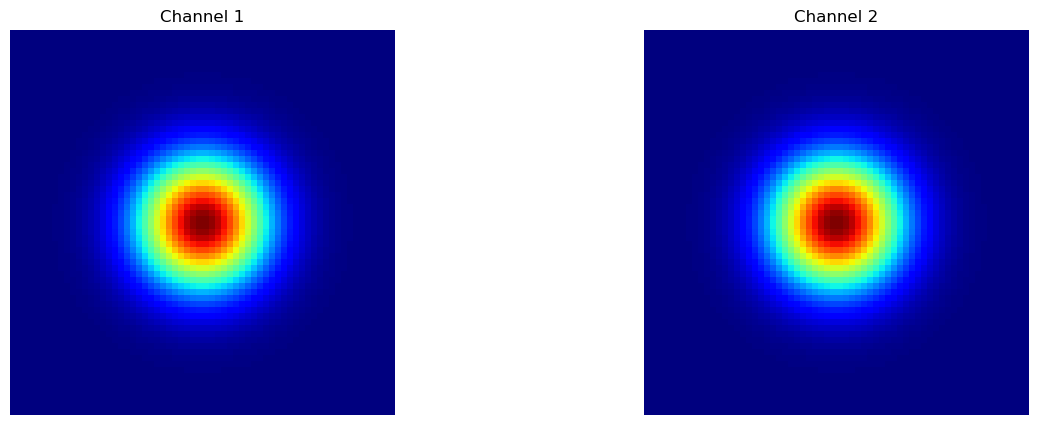

In [11]:
import matplotlib.pyplot as plt

# Assuming `ic` is your tensor for the initial condition
# Extract channels 0, 2, and 3 from the first sample in the batch (batch index 0)
ic_sample = ic[0]  # Choose the first batch element
channels_to_visualize = [1, 2]

# Plot the selected channels
fig, axs = plt.subplots(1, len(channels_to_visualize), figsize=(15, 5))

for i, channel in enumerate(channels_to_visualize):
    axs[i].imshow(ic_sample[channel].detach().cpu().numpy(), cmap='jet')  # or any other colormap
    axs[i].set_title(f'Channel {channel}')
    axs[i].axis('off')

plt.show()


In [12]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_burgers_sample(data_loader, dataset, sample_index=0, save_path=None):
    """
    Visualizes the input condition and ground truth sequence for a given sample in the BurgersDataset.

    Args:
        data_loader (DataLoader): The DataLoader instance.
        dataset (BurgersDataset): The dataset instance.
        sample_index (int): Index of the sample within the batch to visualize (default is 0).
        save_path (str, optional): Path to save the visualization image. If None, the plot is not saved.
    """
    # Get one batch from the DataLoader
    batch = next(iter(data_loader))
    ic_batch, t0, t1, target_batch = batch

    # Select the sample_index from the batch
    ic = ic_batch[sample_index]             # Shape: (3, 64, 64)
    target = target_batch[:, sample_index]   # Shape: (future_steps, 3, 64, 64)

    # Extract channels
    # Channels: 0 - Re, 1 - u, 2 - v
    Re_ic = ic[0].numpy()
    u_ic = ic[1].numpy()
    v_ic = ic[2].numpy()

    # Prepare for visualization
    future_steps = target.shape[0]

    # Create subplots
    # We'll create a figure with (future_steps + 1) rows and 3 columns:
    # 1 row for the input condition and 'future_steps' rows for the targets
    fig, axes = plt.subplots(future_steps + 1, 3, figsize=(18, 5 * (future_steps + 1)))

    # Titles for the channels
    channel_titles = ['Reynolds Number (Re)', 'Velocity u', 'Velocity v']

    # Visualization for Input Condition (ic)
    # Reynolds Number
    Re_scalar = Re_ic[0, 0]
    Re_text = f'Re Reynolds Number (Re): {Re_scalar:.2f}'
    axes[0, 0].text(0.5, 0.5, Re_text, fontsize=12, ha='center', va='center')
    axes[0, 0].set_title(f'IC - {channel_titles[0]}')
    axes[0, 0].axis('off')

    # Velocity u
    im0_u = axes[0, 1].imshow(u_ic, cmap='seismic')
    axes[0, 1].set_title(f'IC - {channel_titles[1]}')
    axes[0, 1].axis('off')
    plt.colorbar(im0_u, ax=axes[0, 1], fraction=0.046, pad=0.04)

    # Velocity v
    im0_v = axes[0, 2].imshow(v_ic, cmap='seismic')
    axes[0, 2].set_title(f'IC - {channel_titles[2]}')
    axes[0, 2].axis('off')
    plt.colorbar(im0_v, ax=axes[0, 2], fraction=0.046, pad=0.04)

    # Add Reynolds Number as a central title above all subplots
    fig.suptitle(Re_text, fontsize=16, y=0.98, ha='center')

    # Visualization for Each Target Timestep
    for step in range(future_steps):
        # Extract target channels
        target_Re = target[step, 0].numpy()
        target_u = target[step, 1].numpy()
        target_v = target[step, 2].numpy()

        # Verify that Re is consistent
        assert np.all(target_Re == target_Re[0, 0]), f"Reynolds number is not consistent for target step {step + 1}!"

        # Reynolds Number
        Re_scalar_target = target_Re[0, 0]
        Re_text_target = f'Re Reynolds Number (Re): {Re_scalar_target:.2f}'
        axes[step + 1, 0].text(0.5, 0.5, Re_text_target, fontsize=12, ha='center', va='center')
        axes[step + 1, 0].set_title(f'Target Step {step + 1} - {channel_titles[0]}')
        axes[step + 1, 0].axis('off')

        # Velocity u
        im_u = axes[step + 1, 1].imshow(target_u, cmap='jet')
        axes[step + 1, 1].set_title(f'Target Step {step + 1} - {channel_titles[1]}')
        axes[step + 1, 1].axis('off')
        plt.colorbar(im_u, ax=axes[step + 1, 1], fraction=0.046, pad=0.04)

        # Velocity v
        im_v = axes[step + 1, 2].imshow(target_v, cmap='jet')
        axes[step + 1, 2].set_title(f'Target Step {step + 1} - {channel_titles[2]}')
        axes[step + 1, 2].axis('off')
        plt.colorbar(im_v, ax=axes[step + 1, 2], fraction=0.046, pad=0.04)

    # Adjust layout and suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate suptitle
    plt.show()

    # Save the plot if a save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Visualization saved to {save_path}")


Exception ignored in: <function BurgersDataset.__del__ at 0x7fe5f0beb880>
Traceback (most recent call last):
  File "/tmp/ipykernel_31975/1720084123.py", line 153, in __del__
AttributeError: 'BurgersDataset' object has no attribute '_memmap_cache'


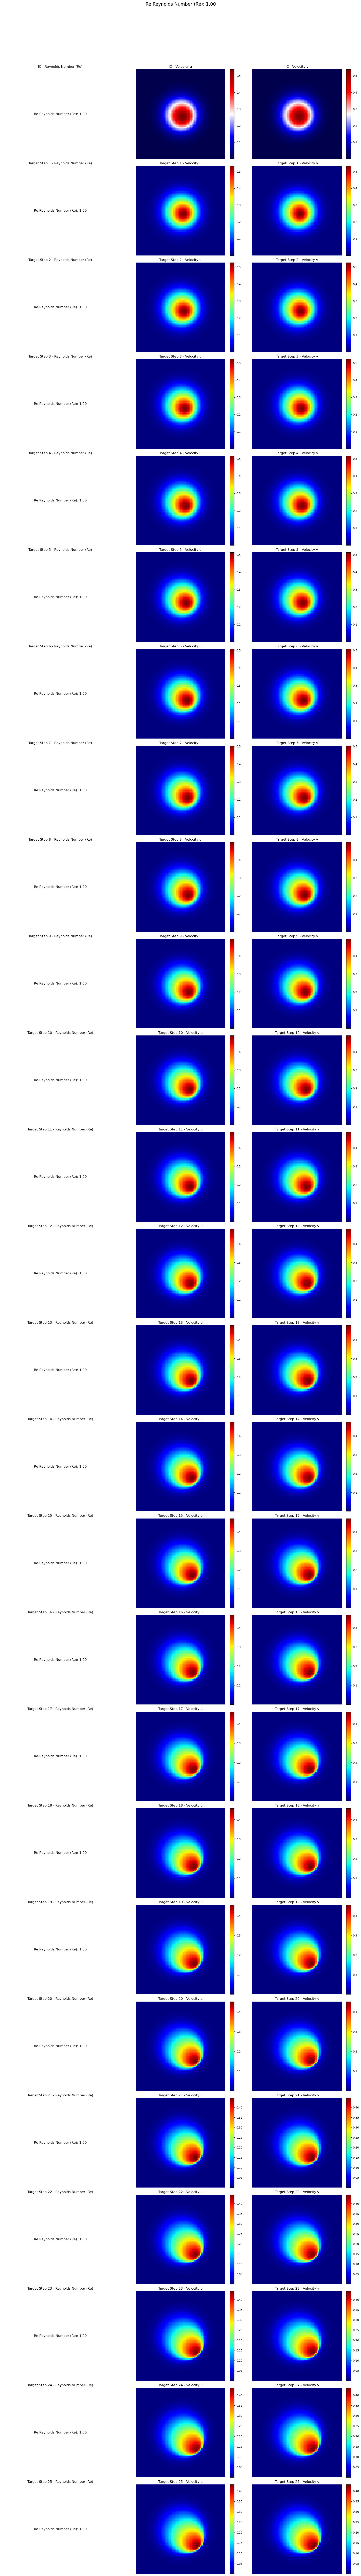

In [16]:
visualize_burgers_sample(data_loader_train, burgers_train_dataset, sample_index=3)